# Воронина Ксения, ПИ19-1 
# Курсовая работа 
# "Машинное обучение в задачах медицинской диагностики"

## Загружаем библиотеки

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # subplots

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import seaborn as sns

## Загружаем датасет

In [2]:
df = pd.read_csv("data.csv", header = 0)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df.shape

(569, 33)

## Очистка и подготовка датасета

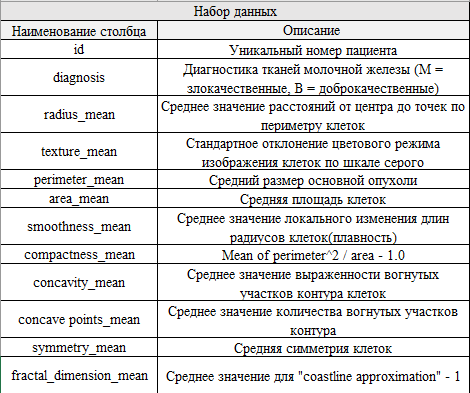

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [5]:
# проверяем данные на пустые значения

print(df.isnull().sum())

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [6]:
df.drop('id', axis=1, inplace=True)          # удаляем стоблец с id, так как никакой информации для нас он не несет
df.drop('Unnamed: 32', axis=1, inplace=True) # удаляем пустой столбец

In [7]:
# проверяем данные на пустые значения

print(df.isnull().sum())

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [8]:
# проверяем, что в датасете действительно только два диагноза: доброкачественная и злокачественная
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [9]:
# преобразование диагнозов в числовые признаки
# 0 - доброкачественная опухоль
# 1 - злокачественная опухоль

df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Описательный анализ данных

In [10]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Кол-во злокачественных диагнозов: 212
Кол-во доброкачественных диагнозов: 357


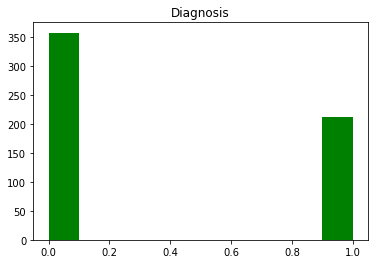

In [11]:
print(f'Кол-во злокачественных диагнозов: {df[df["diagnosis"] == 1].shape[0]}')
print(f'Кол-во доброкачественных диагнозов: {df[df["diagnosis"] == 0].shape[0]}')
plt.hist(df['diagnosis'], color=['g'])
plt.title('Diagnosis')
plt.show()

Корреляционная матрица

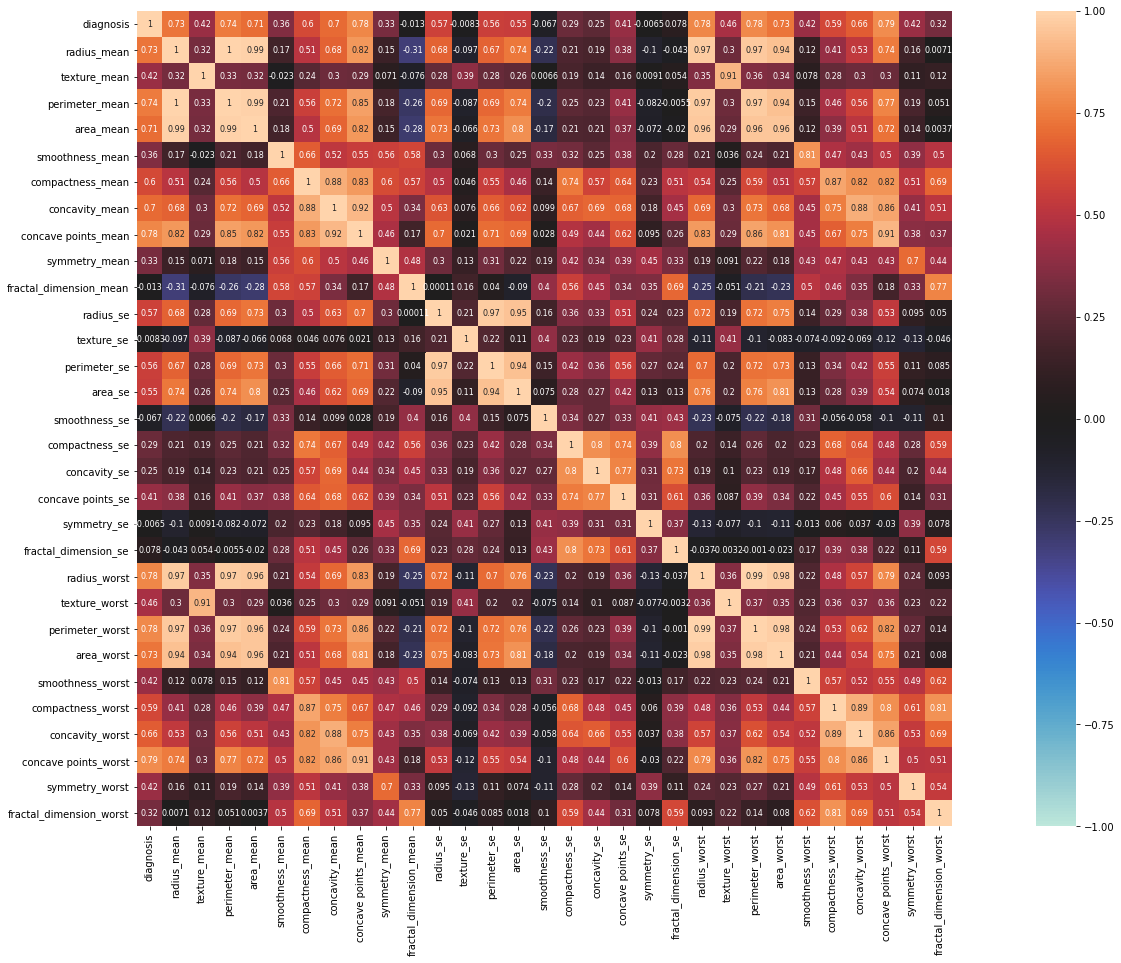

In [12]:
ax = sns.heatmap(df.corr(), annot=True, annot_kws={'size': 8}, vmin=-1, vmax=1, center=0, 
                 square=True, xticklabels=True, yticklabels=True)
ax.figure.set_size_inches(30, 15)

PCA

In [34]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(df.iloc[:,1:])
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['PC1', 'PC2', 'PC3', 'PC4'])
principalDf

,PC1,PC2,PC3,PC4
0,1160.142574,-293.917544,48.578398,-8.711975
1,1269.122443,15.630182,-35.394534,17.861283
2,995.793889,39.156743,-1.709753,4.199340
3,-407.180803,-67.380320,8.672848,-11.759867
4,930.341180,189.340742,1.374801,8.499183
...,...,...,...,...
564,1414.126684,110.222492,40.065944,6.562240
565,1045.018854,77.057589,0.036669,-4.753245
566,314.501756,47.553525,-10.442407,-9.771881
567,1124.858115,34.129225,-19.742087,-23.660881


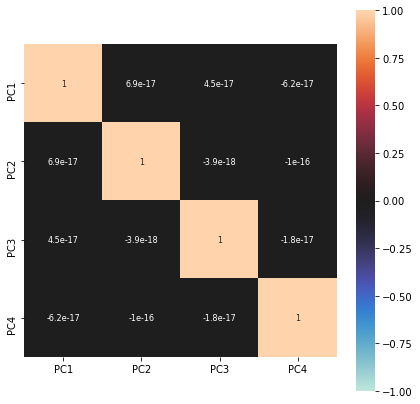

In [37]:
ax = sns.heatmap(principalDf.corr(), annot=True, annot_kws={'size': 8}, vmin=-1, vmax=1, center=0, square=True)
ax.figure.set_size_inches(7, 7)

Построим гистограммы распределения по диагнозам. Это поможет выявить аномальные значения и признаки, которые не несут информацию для нашего случая.

In [20]:
features_mean = list(df.columns[1:])
# разделяет датасет на два по диагнозам
dfM = df[df['diagnosis'] == 1]
dfB = df[df['diagnosis'] == 0]

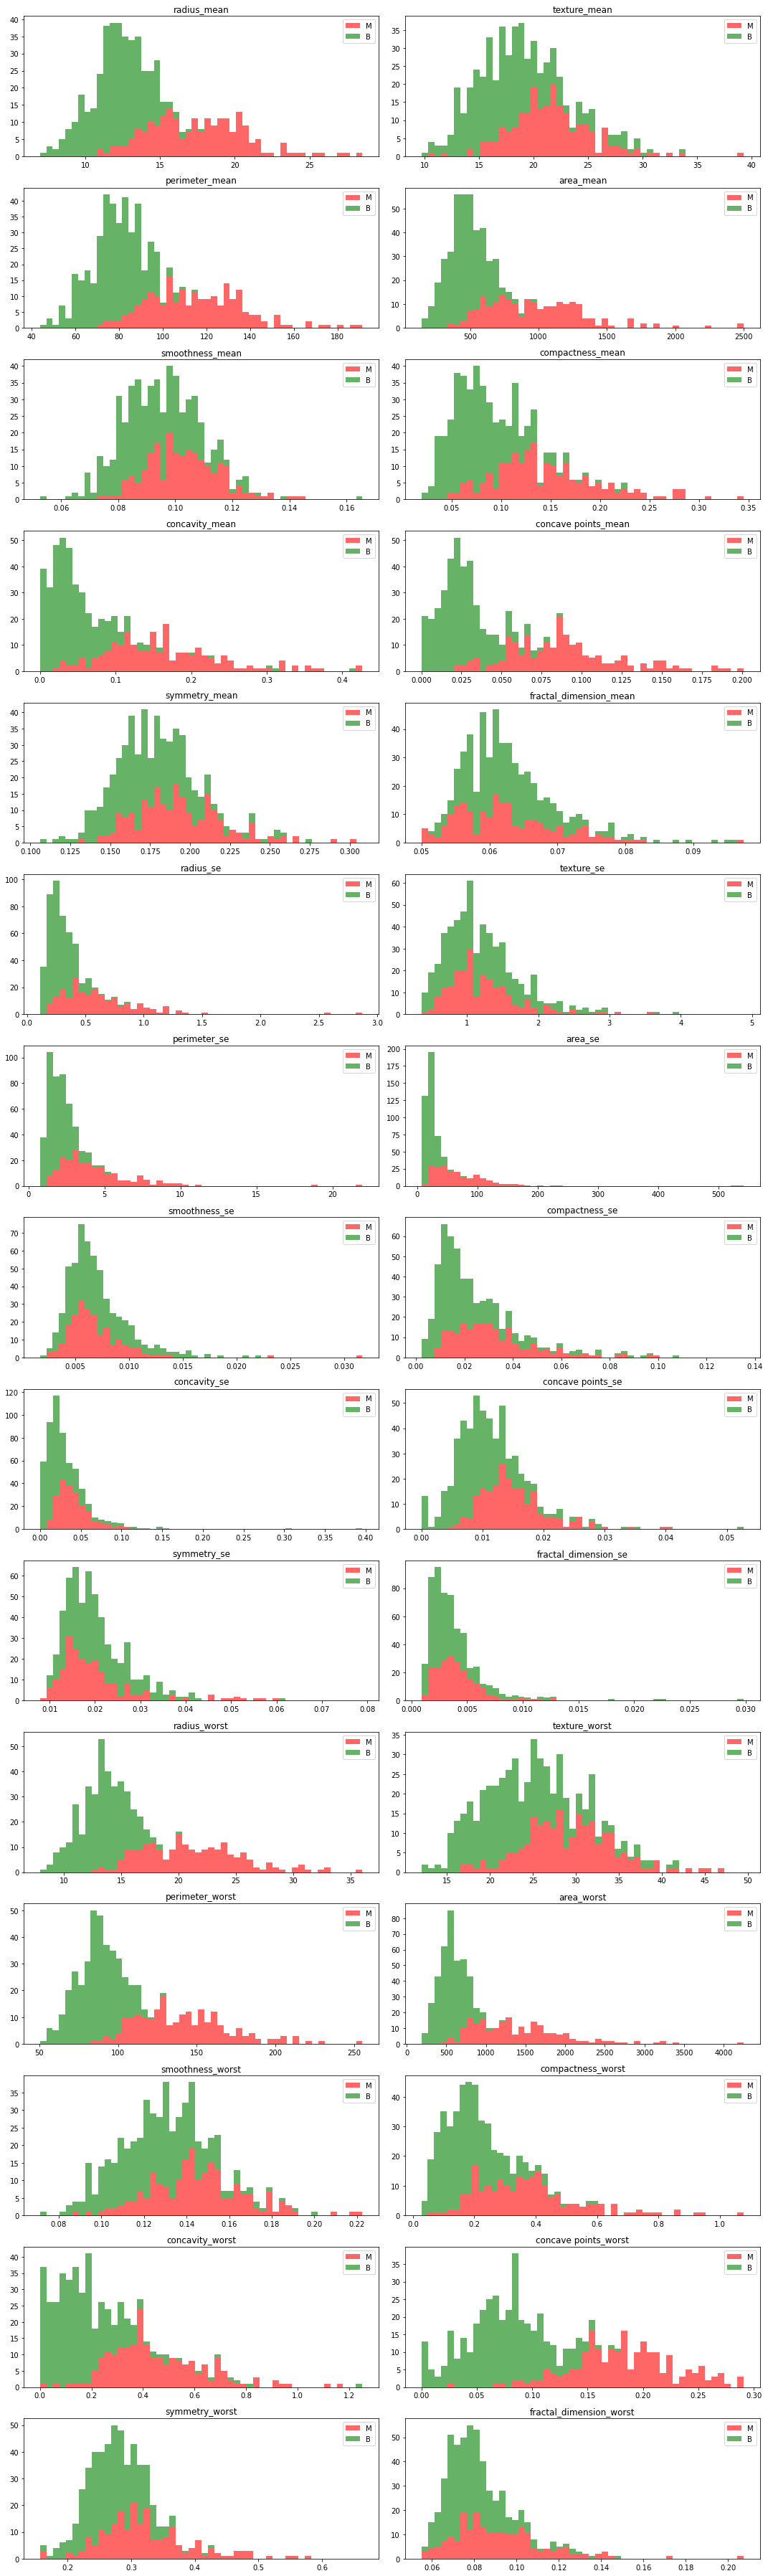

In [21]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(nrows=15, ncols=2, figsize=(15,50))
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.figure
    binwidth= (max(df[features_mean[idx]]) - min(df[features_mean[idx]]))/50
    ax.hist([dfM[features_mean[idx]], dfB[features_mean[idx]]], bins=np.arange(min(df[features_mean[idx]]), 
            max(df[features_mean[idx]]) + binwidth, binwidth) , alpha=0.6,
            stacked=True, rwidth=1, label=['M','B'], color=['r','g'])
    
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])
    
plt.tight_layout()
plt.show()

Выведем несколько точек данных в виде точечной диаграммы от "radius_mean" и "concavity_mean".

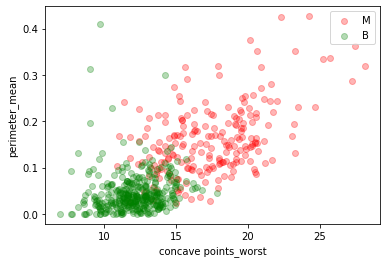

In [22]:
plt.scatter(dfM.radius_mean, dfM.concavity_mean, 
            color="red", label="M",alpha=.29)
plt.scatter(dfB.radius_mean, dfB.concavity_mean, 
            color="green", label = "B", alpha=.29)
plt.xlabel("concave points_worst")
plt.ylabel("perimeter_mean")
plt.legend()
plt.show()

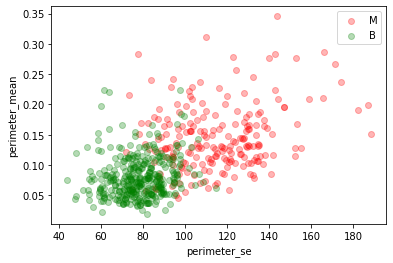

In [23]:
plt.scatter(dfM.perimeter_mean, dfM.compactness_mean, 
            color="red", label="M",alpha=.29)
plt.scatter(dfB.perimeter_mean, dfB.compactness_mean, 
            color="green", label = "B", alpha=.29)
plt.xlabel("perimeter_se")
plt.ylabel("perimeter_mean")
plt.legend()
plt.show() 

##### Выводы

1. Cредние значения radius, perimeter, area, compactness, concavity и concave points могут быть использованы при классификации рака. Большие значения этих параметров, как правило, показывают корреляцию со злокачественными опухолями. 
2. В дальнейшем будем обучать модели на пониженной размерности.
3. Cредние значения texture, smoothness, symmetry и fractal dimension не показывают особого предпочтения одного диагноза перед другим. 
4. Ни на одной из гистограмм нет заметных больших выбросов, которые требуют дальнейшей очистки.

## Обучение моделей

Поскольку этот набор данных не упорядочен, я собираюсь выполнить простое разделение 70:30, чтобы создать набор обучающих данных и набор тестовых данных. После чего построить классификационную модель и оценить ее производительность с помощью тестового набора.

In [39]:
df = pd.concat([df, principalDf], axis=1)
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,PC1,PC2,PC3,PC4
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1160.142574,-293.917544,48.578398,-8.711975
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1269.122443,15.630182,-35.394534,17.861283
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,995.793889,39.156743,-1.709753,4.199340
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,-407.180803,-67.380320,8.672848,-11.759867
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,930.341180,189.340742,1.374801,8.499183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1414.126684,110.222492,40.065944,6.562240
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1045.018854,77.057589,0.036669,-4.753245
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,314.501756,47.553525,-10.442407,-9.771881
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1124.858115,34.129225,-19.742087,-23.660881


In [40]:
traindf, testdf = train_test_split(df, test_size = 0.3)

In [45]:
# Общая функция для создания модели классификации.

def classification_model(model, data, dataTest, predictors, outcome):
  
    model.fit(data[predictors], data[outcome])
  
    # предсказания на тестовой выборке
    predictions = model.predict(dataTest[predictors])
    
    # построим матрицу ошибок
    matrix = metrics.confusion_matrix(dataTest[outcome], predictions)
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(pd.DataFrame(matrix), annot=True)
    plt.ylabel('Действительные значения')
    plt.xlabel('Предсказанные значения')
    
    print('\033[1m'+"Classification_report on test data\n"+'\033[0m')
    print(metrics.classification_report(dataTest[outcome], predictions))
    
    print('\033[1m'+"Перекрестная проверка\n"+'\033[0m')
    # Перекрестная проверка
    kf = KFold(n_splits=10)
    error = []
    dataFull = pd.concat([data, dataTest], ignore_index=True)
    for train, test in kf.split(dataFull):
        train_predictors = dataFull[predictors].iloc[train,:]
        train_target = dataFull[outcome].iloc[train]
        # Обучение алгоритма
        model.fit(train_predictors, train_target)
        pred = model.predict(dataFull[predictors].iloc[test,:])
        
        # Запись ошибки при каждом запуске перекрестной проверки
        error.append(metrics.recall_score(dataFull[outcome].iloc[test], pred))
    
    print(f'Значения Cross-Validation: {error}\n')
    print("Avg Cross-Validation recall_score : %s" % "{0:.3%}".format(np.mean(error)))
    
    print('\033[1m'+'\nМатрица ошибок на тестовых данных\n'+'\033[0m')
    
    
    # Генерация кривой обучения
    size_grid = np.linspace(0.06, 1.0, 10)
    train_size, train_scores, validation_scores = learning_curve(model, 
                                                                 data[predictors], 
                                                                 data[outcome], 
                                                                 cv=10,
                                                                 scoring="recall",
                                                                 train_sizes = size_grid, 
                                                                 n_jobs=1,
                                                                 random_state=123, 
                                                                 shuffle=True)
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(validation_scores, axis=1)

    plt.figure()
    plt.plot(size_grid, train_mean, color = 'red', label = 'train')
    plt.plot(size_grid, test_mean, color = 'green', label = 'test')
    plt.title('Кривая обучения')
    plt.xlabel('Размер выборки')
    plt.ylabel('Точность')
    plt.ylim([0.7,1.05])
    plt.legend(loc='best')
    plt.show()

    #model.fit(data[predictors],data[outcome]) 

In [46]:
??learning_curve

### LogisticRegression

Classification_report on test data

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       104
           1       0.90      0.99      0.94        67

    accuracy                           0.95       171
   macro avg       0.95      0.96      0.95       171
weighted avg       0.96      0.95      0.95       171

Перекрестная проверка

Значения Cross-Validation: [0.8636363636363636, 0.8947368421052632, 0.9545454545454546, 0.9090909090909091, 0.8571428571428571, 0.8260869565217391, 0.8695652173913043, 1.0, 0.9615384615384616, 0.9473684210526315]

Avg Cross-Validation recall_score : 90.837%

Матрица ошибок на тестовых данных



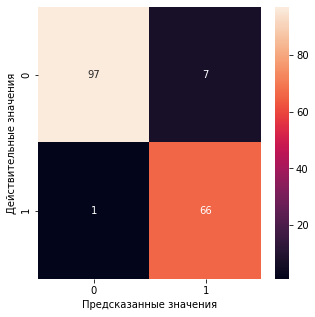

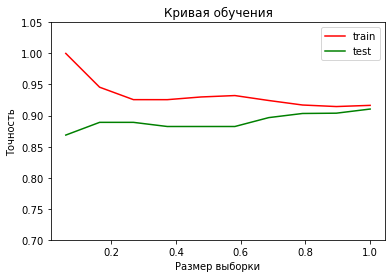

Wall time: 6.93 s


In [62]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = LogisticRegression(max_iter=1000)
classification_model(model, traindf, testdf, predictor_var, outcome_var)

###### Проведем GridSearch

In [48]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'

tuned_parameters = {'C': np.linspace(0.01, 1, 500)}
model = LogisticRegression(solver='lbfgs', max_iter=1000)
grid = GridSearchCV(model, tuned_parameters, cv=10, scoring="recall")
grid.fit(traindf[predictor_var], traindf[outcome_var])
print(grid.best_score_, grid.best_params_)

0.9104761904761907 {'C': 0.14887775551102206}
Wall time: 4min 34s


Обучим модель логистической регрессии с новым параметром регуляризации

Classification_report on test data

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       104
           1       0.90      0.99      0.94        67

    accuracy                           0.95       171
   macro avg       0.95      0.96      0.95       171
weighted avg       0.96      0.95      0.95       171

Перекрестная проверка

Значения Cross-Validation: [0.8636363636363636, 0.8947368421052632, 0.9545454545454546, 0.9090909090909091, 0.8571428571428571, 0.8260869565217391, 0.8695652173913043, 1.0, 0.9615384615384616, 0.9473684210526315]

Avg Cross-Validation recall_score : 90.837%

Матрица ошибок на тестовых данных



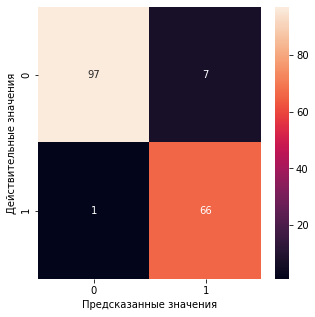

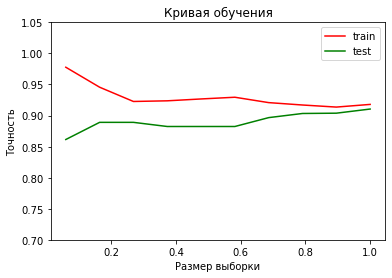

Wall time: 7.14 s


In [49]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = LogisticRegression(solver='lbfgs', max_iter=1000, C = 0.14887775551102206)
classification_model(model, traindf, testdf, predictor_var, outcome_var)

### DecisionTreeModel

Classification_report on test data

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       104
           1       0.88      0.91      0.90        67

    accuracy                           0.92       171
   macro avg       0.91      0.92      0.91       171
weighted avg       0.92      0.92      0.92       171

Перекрестная проверка

Значения Cross-Validation: [0.8181818181818182, 0.7368421052631579, 0.8636363636363636, 0.8636363636363636, 0.7142857142857143, 0.782608695652174, 0.8695652173913043, 0.9090909090909091, 0.9615384615384616, 0.8947368421052632]

Avg Cross-Validation recall_score : 84.141%

Матрица ошибок на тестовых данных



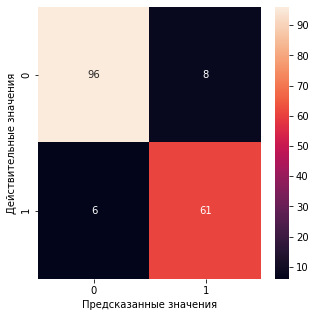

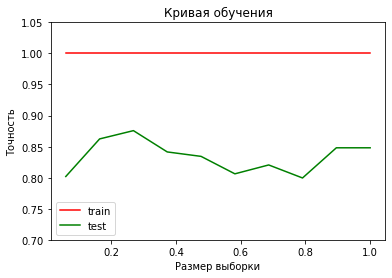

Wall time: 2.59 s


In [61]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = DecisionTreeClassifier()
classification_model(model, traindf, testdf, predictor_var, outcome_var)

###### Проведем GridSearch

In [51]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'

tuned_parameters = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
model = DecisionTreeClassifier()
grid = GridSearchCV(model, tuned_parameters, cv=10, scoring="recall")
grid.fit(traindf[predictor_var], traindf[outcome_var])
print(grid.best_score_, grid.best_params_)

0.9176190476190478 {'criterion': 'entropy', 'max_depth': 6}
Wall time: 3.17 s


Обучим модель с новыми параметрами

Classification_report on test data

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       104
           1       0.93      0.97      0.95        67

    accuracy                           0.96       171
   macro avg       0.95      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171

Перекрестная проверка

Значения Cross-Validation: [0.8636363636363636, 0.8947368421052632, 0.8181818181818182, 0.9090909090909091, 0.8571428571428571, 0.8695652173913043, 0.8695652173913043, 1.0, 0.9230769230769231, 0.7894736842105263]

Avg Cross-Validation recall_score : 87.945%

Матрица ошибок на тестовых данных



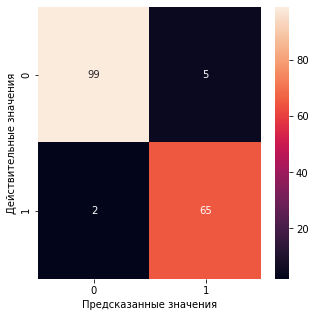

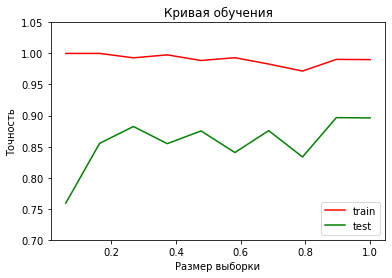

Wall time: 2.57 s


In [52]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = DecisionTreeClassifier(criterion="entropy", max_depth=6)
classification_model(model, traindf, testdf, predictor_var, outcome_var)

### KNeighborsClassifier

Classification_report on test data

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       104
           1       0.86      0.94      0.90        67

    accuracy                           0.92       171
   macro avg       0.91      0.92      0.92       171
weighted avg       0.92      0.92      0.92       171

Перекрестная проверка

Значения Cross-Validation: [0.8636363636363636, 0.8947368421052632, 0.8636363636363636, 0.8636363636363636, 0.7857142857142857, 0.8260869565217391, 0.8260869565217391, 0.9090909090909091, 0.9615384615384616, 1.0]

Avg Cross-Validation recall_score : 87.942%

Матрица ошибок на тестовых данных



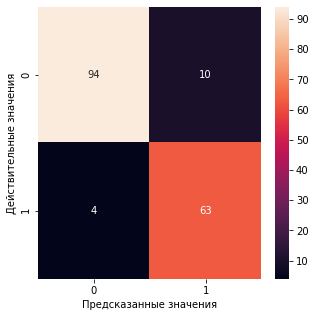

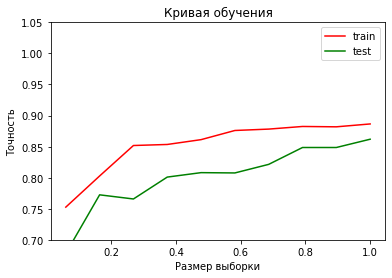

Wall time: 4.29 s


In [53]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = KNeighborsClassifier()
classification_model(model, traindf, testdf, predictor_var, outcome_var)

###### Проведем GridSearch

In [59]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'

k_range = list(range(1, 31))
tuned_parameters = dict(n_neighbors=k_range)
model = KNeighborsClassifier()

grid = GridSearchCV(model, tuned_parameters, cv=10, scoring="recall")
grid.fit(traindf[predictor_var], traindf[outcome_var])
print(grid.best_score_, grid.best_params_)

0.8676190476190475 {'n_neighbors': 1}
Wall time: 4.67 s


Обучим модель с новыми параметрами

Classification_report on test data

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       104
           1       0.85      0.93      0.89        67

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Перекрестная проверка

Значения Cross-Validation: [0.8636363636363636, 0.7368421052631579, 0.8181818181818182, 0.9090909090909091, 0.7857142857142857, 0.7391304347826086, 0.8260869565217391, 0.9545454545454546, 0.9615384615384616, 0.9473684210526315]

Avg Cross-Validation recall_score : 85.421%

Матрица ошибок на тестовых данных



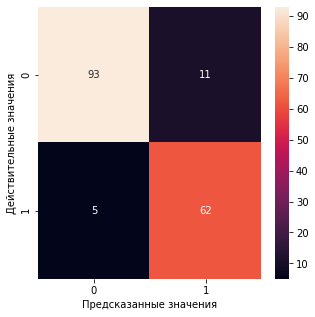

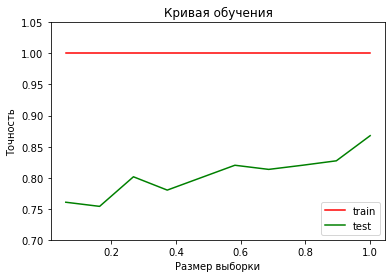

Wall time: 4.38 s


In [63]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = KNeighborsClassifier(n_neighbors=1)
classification_model(model, traindf, testdf, predictor_var, outcome_var)

### GradientBoostingClassifier

Classification_report on test data

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       104
           1       0.93      0.99      0.96        67

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.97       171

Перекрестная проверка

Значения Cross-Validation: [0.9545454545454546, 0.8421052631578947, 0.9090909090909091, 0.9090909090909091, 0.8571428571428571, 0.8695652173913043, 0.9130434782608695, 1.0, 0.9615384615384616, 0.9473684210526315]

Avg Cross-Validation recall_score : 91.635%

Матрица ошибок на тестовых данных



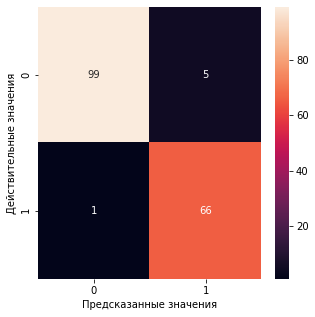

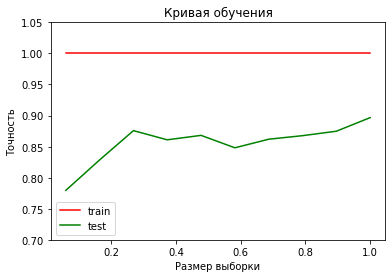

Wall time: 20.7 s


In [64]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = GradientBoostingClassifier()
classification_model(model, traindf, testdf, predictor_var, outcome_var)

###### Проведем GridSearch

In [65]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'

tuned_parameters = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8]}
model = GradientBoostingClassifier()

grid = GridSearchCV(model, tuned_parameters, cv=10, scoring="recall")
grid.fit(traindf[predictor_var], traindf[outcome_var])
print(grid.best_score_, grid.best_params_)

0.9176190476190478 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.9}
Wall time: 23min 17s


Обучим модель с новыми параметрами

Classification_report on test data

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       104
           1       0.94      0.99      0.96        67

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

Перекрестная проверка

Значения Cross-Validation: [0.9090909090909091, 0.8421052631578947, 0.9090909090909091, 0.9090909090909091, 0.8571428571428571, 0.8695652173913043, 0.9130434782608695, 1.0, 0.9615384615384616, 0.9473684210526315]

Avg Cross-Validation recall_score : 91.180%

Матрица ошибок на тестовых данных



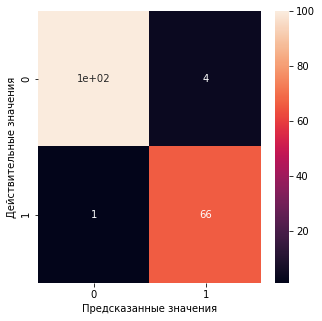

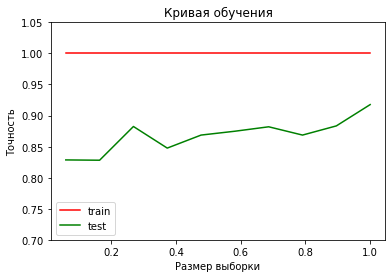

Wall time: 1min 15s


In [66]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = GradientBoostingClassifier(learning_rate=0.01, subsample=0.9, n_estimators=500, max_depth=6)
classification_model(model, traindf, testdf, predictor_var, outcome_var)

### AdaBoostClassifier

Classification_report on test data

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       104
           1       0.90      0.96      0.93        67

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Перекрестная проверка

Значения Cross-Validation: [0.8636363636363636, 0.8421052631578947, 0.8181818181818182, 0.8636363636363636, 0.9285714285714286, 0.9130434782608695, 0.9130434782608695, 1.0, 0.9615384615384616, 0.8947368421052632]

Avg Cross-Validation recall_score : 89.985%

Матрица ошибок на тестовых данных



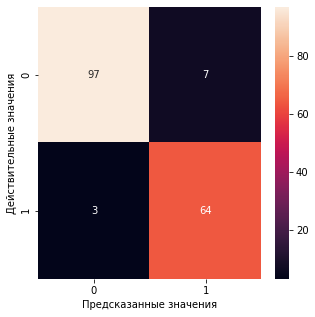

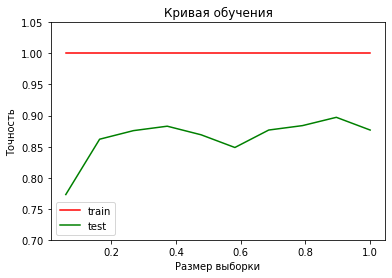

Wall time: 8.15 s


In [67]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = AdaBoostClassifier()
classification_model(model, traindf, testdf, predictor_var, outcome_var)

###### Проведем GridSearch

In [68]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'

tuned_parameters = {'n_estimators': range(1, 100)}
model = AdaBoostClassifier()
                    
grid = GridSearchCV(model, tuned_parameters, cv=10, scoring="recall")
grid.fit(traindf[predictor_var], traindf[outcome_var])
print(grid.best_score_, grid.best_params_)

0.8971428571428571 {'n_estimators': 93}
Wall time: 1min 4s


Обучим модель с новыми параметрами

Classification_report on test data

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       104
           1       0.91      0.96      0.93        67

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

Перекрестная проверка

Значения Cross-Validation: [0.8181818181818182, 0.8421052631578947, 0.8181818181818182, 0.8636363636363636, 0.9285714285714286, 0.8695652173913043, 0.9130434782608695, 1.0, 0.9615384615384616, 0.8947368421052632]

Avg Cross-Validation recall_score : 89.096%

Матрица ошибок на тестовых данных



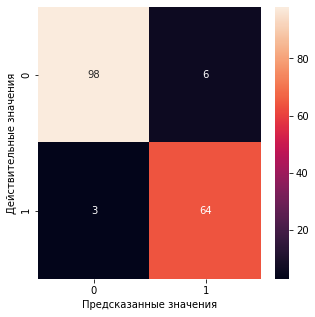

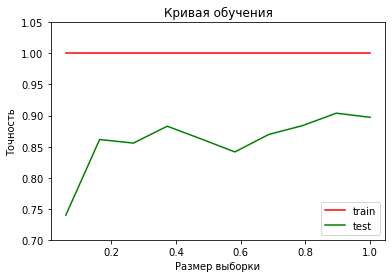

Wall time: 16.3 s


In [69]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = AdaBoostClassifier(n_estimators=93)
classification_model(model, traindf, testdf, predictor_var, outcome_var)

### SVC

Classification_report on test data

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       104
           1       0.97      0.96      0.96        67

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

Перекрестная проверка

Значения Cross-Validation: [0.7727272727272727, 0.7368421052631579, 0.8181818181818182, 0.8636363636363636, 0.7142857142857143, 0.782608695652174, 0.782608695652174, 0.9545454545454546, 1.0, 0.9473684210526315]

Avg Cross-Validation recall_score : 83.728%

Матрица ошибок на тестовых данных



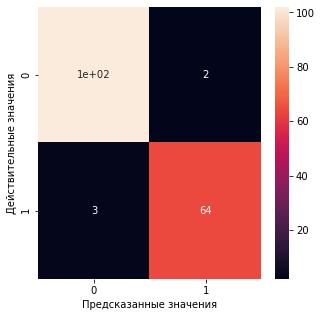

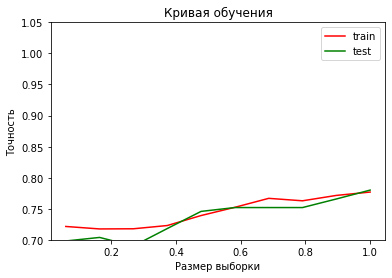

Wall time: 1.06 s


In [70]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = SVC()
classification_model(model, traindf, testdf, predictor_var, outcome_var)

###### Проведем GridSearch

In [71]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'

tuned_parameters = {'C': np.linspace(0.01, 1, 300), 'kernel': ['linear', 'poly', 'rbf']}
model = SVC()
                    
grid = GridSearchCV(model, tuned_parameters, cv=10, scoring="recall")
grid.fit(traindf[predictor_var], traindf[outcome_var])
print(grid.best_score_, grid.best_params_)

0.9104761904761907 {'C': 0.01, 'kernel': 'linear'}
Wall time: 23min 55s


Обучим модель с новыми параметрами

Classification_report on test data

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       104
           1       0.93      0.94      0.93        67

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Перекрестная проверка

Значения Cross-Validation: [0.8636363636363636, 0.8947368421052632, 0.9545454545454546, 0.9090909090909091, 0.8571428571428571, 0.8260869565217391, 0.8260869565217391, 1.0, 0.9230769230769231, 0.9473684210526315]

Avg Cross-Validation recall_score : 90.018%

Матрица ошибок на тестовых данных



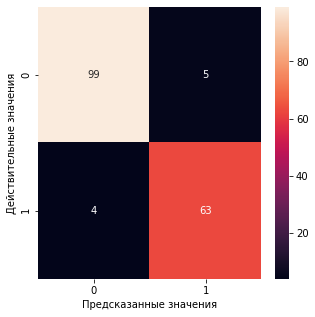

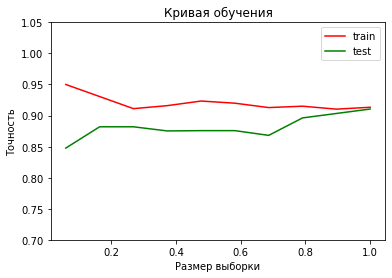

Wall time: 2.19 s


In [75]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = SVC(kernel='linear', C=0.01)
classification_model(model, traindf, testdf, predictor_var, outcome_var)

### RandomForestClassifier

Classification_report on test data

              precision    recall  f1-score   support

           0       1.00      0.93      0.97       104
           1       0.91      1.00      0.95        67

    accuracy                           0.96       171
   macro avg       0.95      0.97      0.96       171
weighted avg       0.96      0.96      0.96       171

Перекрестная проверка

Значения Cross-Validation: [0.9090909090909091, 0.8947368421052632, 0.9090909090909091, 0.9090909090909091, 0.8571428571428571, 0.8695652173913043, 0.8695652173913043, 1.0, 1.0, 0.9473684210526315]

Avg Cross-Validation recall_score : 91.657%

Матрица ошибок на тестовых данных



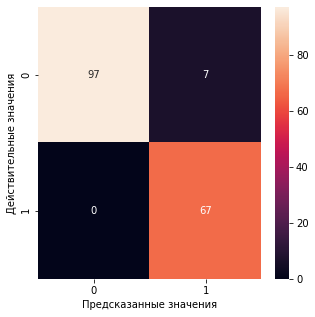

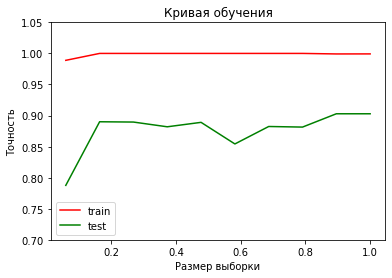

Wall time: 15.7 s


In [77]:
%%time

predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = RandomForestClassifier()
classification_model(model, traindf, testdf, predictor_var, outcome_var)

In [78]:
featimp = pd.Series(model.feature_importances_, index = predictor_var).sort_values(ascending=False)
print(featimp[:5])

PC1    0.629895
PC4    0.164487
PC3    0.103160
PC2    0.102458
dtype: float64


Использование топ-5 признаков лишь немного изменяет точность прогнозирования.

###### Проведем GridSearch

In [74]:
%%time
predictor_var = ['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'

tuned_parameters = {'n_estimators': [10, 50, 100, 150, 200, 300],
                    'max_depth': range(2,15),
                    'min_samples_split': range(2,15)}

model = RandomForestClassifier()
                    
grid = GridSearchCV(model, tuned_parameters, cv=10, scoring="recall")
grid.fit(traindf[predictor_var], traindf[outcome_var])
print(grid.best_score_, grid.best_params_)

0.9314285714285715 {'max_depth': 12, 'min_samples_split': 7, 'n_estimators': 10}
Wall time: 2h 20min 41s


Обучим модель с новыми параметрами

Classification_report on test data

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       104
           1       0.90      0.99      0.94        67

    accuracy                           0.95       171
   macro avg       0.95      0.96      0.95       171
weighted avg       0.96      0.95      0.95       171

Перекрестная проверка

Значения Cross-Validation: [0.9090909090909091, 0.8421052631578947, 0.9090909090909091, 0.9090909090909091, 0.8571428571428571, 0.8695652173913043, 0.8695652173913043, 1.0, 1.0, 0.9473684210526315]

Avg Cross-Validation recall_score : 91.130%

Матрица ошибок на тестовых данных



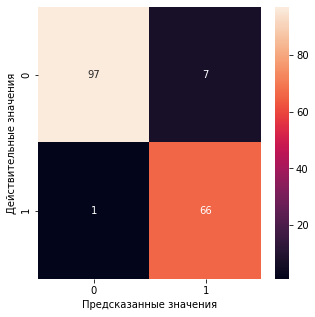

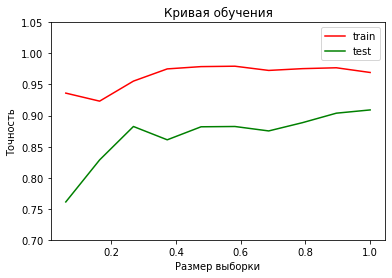

Wall time: 2.77 s


In [79]:
%%time
predictor_var =['PC1', 'PC2', 'PC3', 'PC4']
outcome_var = 'diagnosis'
model = RandomForestClassifier(n_estimators=10, max_depth=12, min_samples_split=7)
classification_model(model, traindf, testdf, predictor_var, outcome_var)